### 시황을 고려한 투자의 중요성
- 증시를 경제 사이클에 따라 분류
- 각 시황별 주식, 채권, 원자재, 달러의 대표 지수의 성과지표를 비교분석해본다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px
import time

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import yfinance as yf
from fredapi import Fred

import sys
sys.path.append("/Users/jtchoi/Library/CloudStorage/GoogleDrive-jungtaek0227@gmail.com/My Drive/quant/Quant-Project/quant")
from backtest.metric import *
from econ_regime.econ_regime import *

### 데이터 로드

In [2]:
sp500 = yf.download('SPY')['Adj Close']
sp500.index = pd.to_datetime(pd.to_datetime(sp500.index).date)
sp500 = sp500.resample('M').last()
sp500 = sp500.iloc[:-1]

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500

1993-01-31     25.218225
1993-02-28     25.487265
1993-03-31     26.058153
1993-04-30     25.391394
1993-05-31     26.076183
                 ...    
2022-09-30    355.547302
2022-10-31    384.444611
2022-11-30    405.816467
2022-12-31    382.429993
2023-01-31    406.480011
Freq: M, Name: Adj Close, Length: 361, dtype: float64

### 미국경제를 디플레이션, 인플레이션, 회복기, 확장기로 분류

    정의:
      - OECD 미국 경기선행지수: 장단기금리차, 종합주가지수, 제조업 업황지수, 제조업 주간노동시간, 소비자신뢰지수, 내구재 신규주문, 주택착공건수
      - OECD 경기선행지수 100pt를 기준으로 고성장과 저성장으로 나눔
      - OECD 경기선행지수를 바탕으로 성장 상승 및 하락 추세 반영
      - Core PCE 물가지수 2.5%를 기준으로 고인플레이션과 저인플레이션으로 나눔

    국면:
      - deflation: 저성장/성장 하락 추세/저인플레이션
      - inflation: 저성장/성장 하락 추세/고인플레이션
      - recovery: 저성장/성장 상승 추세/저인플레이션, 저성장/성장 상승 추세/고인플레이션
      - expansion: 고성장/성장 상승 추세/고인플레이션, 고성장/성장 하락 추세/고인플레이션

In [4]:
regime_df = business_cycle()
regime_df.to_csv

<bound method NDFrame.to_csv of             deflation  inflation  recovery  expansion
1994-01-01          0          0         0          1
1994-02-01          0          0         0          1
1994-03-01          0          0         0          1
1994-04-01          0          0         0          1
1994-05-01          0          0         0          1
...               ...        ...       ...        ...
2022-09-01          0          1         0          0
2022-10-01          0          1         0          0
2022-11-01          0          1         0          0
2022-12-01          0          1         0          0
2023-01-01          0          1         0          0

[349 rows x 4 columns]>

In [5]:
regime_df.index = sp500.loc['1994':].index
regime_df = pd.concat([sp500.pct_change(), regime_df], axis=1).dropna()
regime_df.columns = ['sp500_rets', 'deflation', 'inflation', 'recovery', 'expansion']
regime_df

,sp500_rets,deflation,inflation,recovery,expansion
1994-01-31,0.034876,0.0,0.0,0.0,1.0
1994-02-28,-0.029164,0.0,0.0,0.0,1.0
1994-03-31,-0.041901,0.0,0.0,0.0,1.0
1994-04-30,0.011212,0.0,0.0,0.0,1.0
1994-05-31,0.015939,0.0,0.0,0.0,1.0
...,...,...,...,...,...
2022-09-30,-0.092446,0.0,1.0,0.0,0.0
2022-10-31,0.081276,0.0,1.0,0.0,0.0
2022-11-30,0.055592,0.0,1.0,0.0,0.0
2022-12-31,-0.057628,0.0,1.0,0.0,0.0


In [6]:
# _list = ['returns', 'CAGR', 'volatility', 'MDD', 'sharp']
# _regime = ['deflation',	'inflation','recovery',	'expansion']

### 국면별 sp500 index의 성과지표를 확인
    - 1. sp500에 그대로 투자한 경우
    - 2. sp500에 국면을 반영한 투자의 성과지표들

### sp500 w/o market regime 

<AxesSubplot: title={'center': 'S&P 500'}>

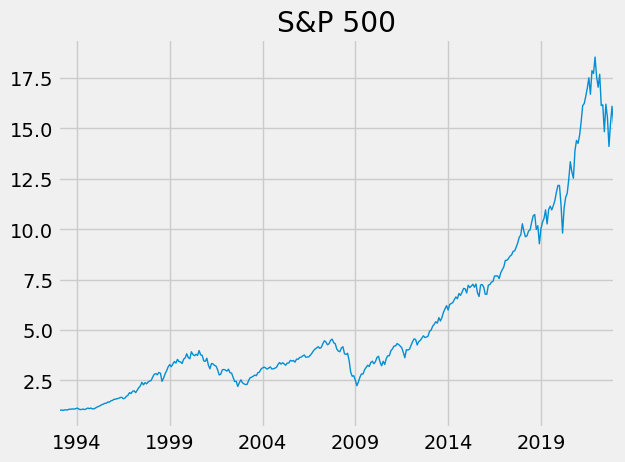

In [7]:
(1 + sp500.pct_change()).cumprod().plot(title='S&P 500', lw=1)

In [8]:
Metric(portfolio=(1 + sp500.pct_change()).cumprod(), freq='month').numeric_metric()

{'returns': '1594.84',
 'CAGR': '9.64',
 'volatility': '0.15',
 'skewness': '-0.58',
 'kurtosis': '0.98',
 'MDD': '-0.51',
 'MDD_duration': '2252.00',
 'sharp': '0.38',
 'sortino': '0.75',
 'calmar': '0.19',
 'VaR': '-0.11',
 'VaR_ratio': '0.08',
 'CVaR': '-0.13',
 'CVaR_ratio': '0.06',
 'hit': '0.65',
 'GtP': '0.91'}

In [9]:
_list = ['returns', 'CAGR', 'volatility', 'MDD','sharp']
sp_bt = Metric(portfolio=(1 + sp500.pct_change()).cumprod(), freq='month').numeric_metric()

_dict = {}
for i in _list:
    _dict[i] = [sp_bt[i]]

sp_bt = pd.DataFrame(_dict, index=['SP500']).T
sp_bt

,SP500
returns,1594.84
CAGR,9.64
volatility,0.15
MDD,-0.51
sharp,0.38


In [10]:
_list = ['returns', 'CAGR', 'volatility', 'MDD', 'sharp']
_regime = ['deflation',	'inflation','recovery',	'expansion']

_dict = []
for i in _regime:
    temp = {}
    for j in _list:
        temp[j] = [Metric(portfolio=(1 + regime_df[regime_df[i]==1].sp500_rets).cumprod(), freq='month').numeric_metric()[j]]
    _dict.append(pd.DataFrame(temp, index=[f'{i}']).T)
    

In [11]:
temp = pd.concat(_dict, axis=1)
final = pd.concat([sp_bt, temp], axis=1)
final

,SP500,deflation,inflation,recovery,expansion
returns,1594.84,63.88,108.69,495.83,326.88
CAGR,9.64,-6.42,13.31,26.05,17.11
volatility,0.15,0.22,0.24,0.12,0.10
MDD,-0.51,-0.65,-0.13,-0.08,-0.11
sharp,0.38,-0.48,0.38,1.90,1.27


In [12]:
sp_bt

,SP500
returns,1594.84
CAGR,9.64
volatility,0.15
MDD,-0.51
sharp,0.38


### sp500 with market regime

In [13]:
### 계산 방법에 대한 설명 
### 스토리 진행에 대한 간단한 힌트를 제공해서 청취자의 이해를 돕는다. -> 두괄식으로 내용을 설명하고, 이해를 돕는다.
### 성과지표를 테이블로 보여준다. -> 테이블을 보여주고, 이해를 돕는다.
### 인덱스는 성과지표 개수, 컬럼은 5개(시황 + 아무것도 안했을 때)

### sp500 with deflation

{'returns': '65.66',
 'CAGR': '-1.44',
 'volatility': '0.10',
 'skewness': '-0.79',
 'kurtosis': '8.21',
 'MDD': '-0.65',
 'MDD_duration': '8950.00',
 'sharp': '-0.52',
 'sortino': '-0.58',
 'calmar': '-0.02',
 'VaR': '-0.11',
 'VaR_ratio': '-0.01',
 'CVaR': '-0.13',
 'CVaR_ratio': '-0.01',
 'hit': '0.53',
 'GtP': '0.78'}

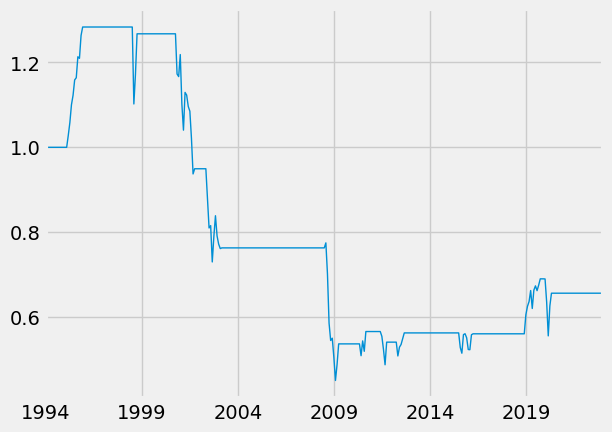

In [14]:
#Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.deflation).cumprod(), freq='month').numeric_metric()
(1 + regime_df.sp500_rets * regime_df.deflation).cumprod().plot(lw=1)
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.deflation).cumprod(), freq='month').numeric_metric()

In [15]:
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.deflation).cumprod(), freq='month').print_report()

Total Returns: 65.66%
CAGR: -1.44%
Annualized Volatility: 10.41%
Skewness: -0.79
Kurtosis: 8.21
Max Drawdown: -64.85%
Max Drawdown Duration: 8950.00 days
Annualized Sharp Ratio: -0.52
Annualized Sortino Ratio: -0.58
Annualized Calmar Ratio: -0.02
Annualized VaR: -0.11
Annualized VaR Ratio: -0.01
Annualized CVaR: -0.13
Annualized CVaR Ratio: -0.01
Annualized hit Ratio: 0.53
Annualized GtP Ratio: 0.78


### sp500 with inflation

<AxesSubplot: >

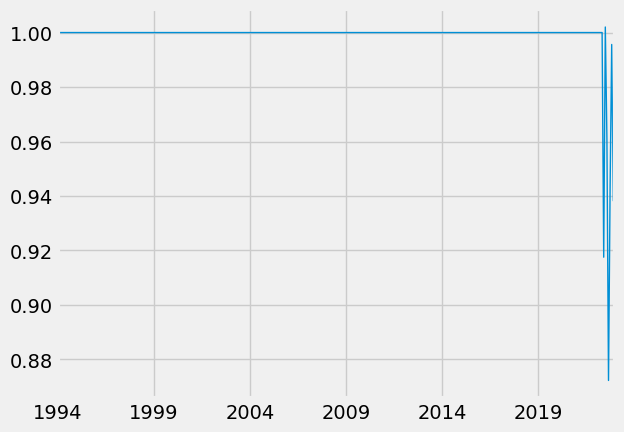

In [16]:
(1 + regime_df.sp500_rets * regime_df.inflation).cumprod().plot(lw=1)

In [17]:
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.inflation).cumprod(), freq='month').print_report()

Total Returns: 99.73%
CAGR: -0.01%
Annualized Volatility: 3.83%
Skewness: 0.26
Kurtosis: 50.74
Max Drawdown: -12.95%
Max Drawdown Duration: 184.00 days
Annualized Sharp Ratio: -1.05
Annualized Sortino Ratio: -1.14
Annualized Calmar Ratio: -0.00
Annualized VaR: -0.02
Annualized VaR Ratio: 0.00
Annualized CVaR: -0.07
Annualized CVaR Ratio: 0.00
Annualized hit Ratio: 0.50
Annualized GtP Ratio: 1.07


### sp500 with recovery

<AxesSubplot: >

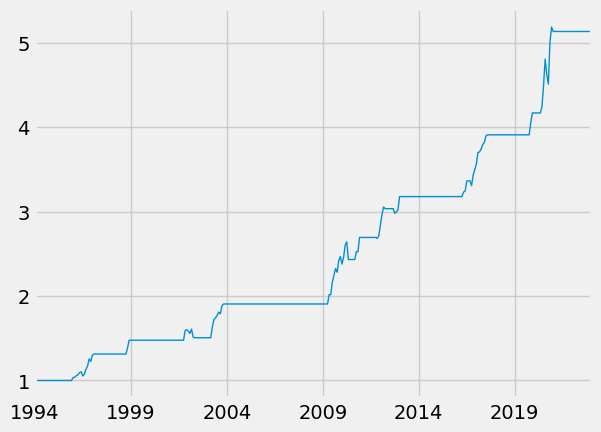

In [18]:
(1 + regime_df.sp500_rets * regime_df.recovery).cumprod().plot(lw=1)

In [19]:
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.recovery).cumprod(), freq='month').print_report()

Total Returns: 513.48%
CAGR: 5.79%
Annualized Volatility: 6.39%
Skewness: 1.92
Kurtosis: 8.44
Max Drawdown: -7.95%
Max Drawdown Duration: 761.00 days
Annualized Sharp Ratio: 0.28
Annualized Sortino Ratio: 1.16
Annualized Calmar Ratio: 0.73
Annualized VaR: -0.04
Annualized VaR Ratio: 0.13
Annualized CVaR: -0.05
Annualized CVaR Ratio: 0.09
Annualized hit Ratio: 0.78
Annualized GtP Ratio: 1.40


### sp500 with expansion

<AxesSubplot: >

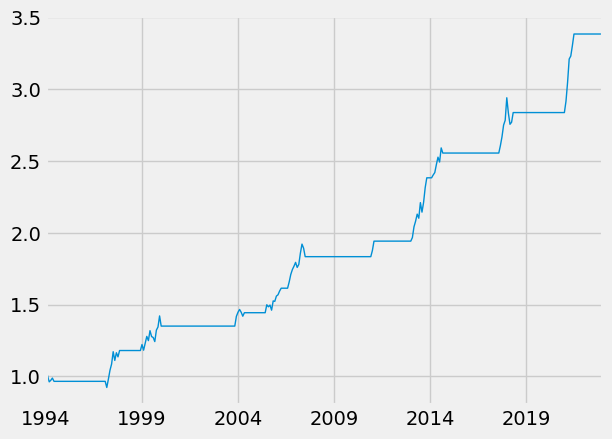

In [20]:
(1 + regime_df.sp500_rets * regime_df.expansion).cumprod().plot(lw=1)

In [21]:
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.expansion).cumprod(), freq='month').print_report()

Total Returns: 326.88%
CAGR: 4.16%
Annualized Volatility: 5.60%
Skewness: 1.28
Kurtosis: 4.96
Max Drawdown: -10.75%
Max Drawdown Duration: 1461.00 days
Annualized Sharp Ratio: 0.03
Annualized Sortino Ratio: 0.45
Annualized Calmar Ratio: 0.39
Annualized VaR: -0.04
Annualized VaR Ratio: 0.09
Annualized CVaR: -0.05
Annualized CVaR Ratio: 0.08
Annualized hit Ratio: 0.71
Annualized GtP Ratio: 1.20


- 시황 적용의 필요성 인지
- recovery인 경우 가장 성과지표가 좋았다.
- 각 국면 별 투자성과가 좋은 자산군을 찾아보자.

### 자산군
    - 주식: sp500 index
    - 장기채권: TLT ETF
    - 원자재: GSG ETF(tracking S&P GSCI index)
    - 달러: UUP index
    - 부동산: VNQ ETF


In [22]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

In [23]:
asset_ticker = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
asset_df = asset_indicators(asset_ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
asset_df = asset_df.loc['2011-01-01':,:].dropna().resample('M').last()

In [25]:
asset_df

,SPY,TLT,GSG,VNQ,UUP
2011-01-31,102.406509,67.367386,35.160000,35.752136,21.478441
2011-02-28,105.963837,68.479042,36.090000,37.434372,21.219084
2011-03-31,105.976562,68.499115,37.349998,36.831417,20.930914
2011-04-30,109.045784,70.101395,38.939999,38.947964,20.124031
2011-05-31,107.822906,72.500854,36.270000,39.483391,20.498655
...,...,...,...,...,...
2022-10-31,384.444611,95.170639,21.850000,81.823532,29.767994
2022-11-30,405.816467,101.976341,21.590000,86.852455,28.360384
2022-12-31,382.429993,99.304520,21.230000,82.480003,27.809999
2023-01-31,406.480011,106.894997,21.209999,91.059998,27.510000


In [26]:
ma_regime_df = pd.merge(asset_df.pct_change(), regime_df, left_index=True, right_index=True, how='left').dropna()
ma_regime_df

multi_asset_tickers = ['SPY', 'TLT', 'GSG', 'VNQ', 'UUP']

In [27]:
ma_regime_df['deflation',	'inflation',	'recovery',	'expansion']

KeyError: ('deflation', 'inflation', 'recovery', 'expansion')

### 회복국면

<AxesSubplot: >

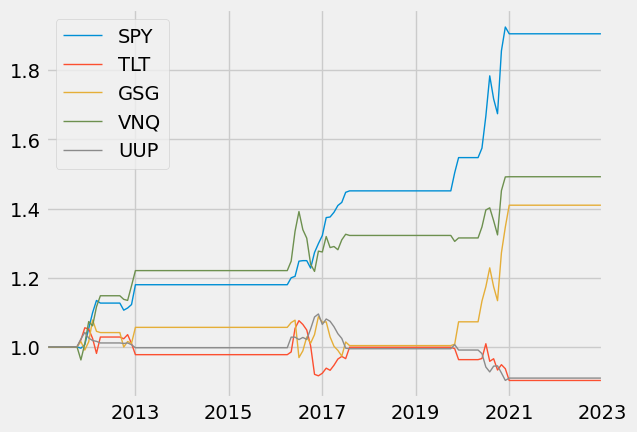

In [28]:
(1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['recovery'], axis=0)).cumprod().plot(lw=1)

In [29]:
dict_ = {}
for ticker in multi_asset_tickers:
    dict_[ticker] = Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.recovery).cumprod(), freq='month').numeric_metric()

In [30]:
pd.DataFrame(dict_)

,SPY,TLT,GSG,VNQ,UUP
returns,190.57,90.26,140.97,149.21,90.95
CAGR,5.52,-0.85,2.90,3.39,-0.79
volatility,0.06,0.05,0.07,0.06,0.03
skewness,3.12,-0.64,1.13,1.89,-0.14
kurtosis,14.32,10.46,11.40,8.73,7.50
MDD,-0.06,-0.16,-0.11,-0.12,-0.18
MDD_duration,761.00,2375.00,1736.00,1430.00,2222.00
sharp,0.27,-0.92,-0.15,-0.10,-1.61
sortino,1.67,-0.99,-0.02,0.14,-1.78
calmar,0.90,-0.05,0.28,0.27,-0.04


In [31]:
_list = ['returns', 'CAGR', 'volatility', 'MDD', 'sharp']
_regime = ['deflation',	'inflation','recovery',	'expansion']
multi_asset_tickers = ['SPY', 'TLT', 'GSG', 'VNQ', 'UUP']

wow = {}
for ticker in multi_asset_tickers:
    _dict = []
    for i in _regime:
        temp = {}
        for j in _list:
            temp[j] = [Metric(portfolio=(1 + ma_regime_df[ma_regime_df[i]==1][ticker]).cumprod(), freq='month').numeric_metric()[j]]
        _dict.append(pd.DataFrame(temp, index=[f'{ticker}: {i}']).T)
    wow[ticker] = _dict

In [32]:
total = pd.concat([pd.concat([wow['SPY'][0], wow['SPY'][1], wow['SPY'][2], wow['SPY'][3]], axis=1).T,
           pd.concat([wow['TLT'][0], wow['TLT'][1], wow['TLT'][2], wow['TLT'][3]], axis=1).T,
           pd.concat([wow['GSG'][0], wow['GSG'][1], wow['GSG'][2], wow['GSG'][3]], axis=1).T,
           pd.concat([wow['VNQ'][0], wow['VNQ'][1], wow['VNQ'][2], wow['VNQ'][3]], axis=1).T,
           pd.concat([wow['UUP'][0], wow['UUP'][1], wow['UUP'][2], wow['UUP'][3]], axis=1).T])

In [33]:
total[::4]
total[1::4]
total[2::4]
total[3::4]

,returns,CAGR,volatility,MDD,sharp
SPY: expansion,174.23,21.65,0.08,-0.06,2.15
TLT: expansion,95.11,-1.76,0.10,-0.19,-0.57
GSG: expansion,132.80,10.53,0.13,-0.17,0.50
VNQ: expansion,124.42,8.02,0.13,-0.17,0.30
UUP: expansion,110.79,3.68,0.06,-0.05,-0.05


### 결과
     - recovery: 저성장/성장 상승 추세/저인플레이션, 저성장/성장 상승 추세/고인플레이션
     - 경제가 회복하는 국면
     - 주식과 부동산 등 위험자산이 가장 좋은 성과를 보임
     - 경제와 인플레이션이 점차 회복되어 채권금리가 상승 -> 장기채권은 불리
     - 저성장 -> 원자재 역시 횡보하는 경향을 보임
       - 예외: 코로나 이후의 급등

### 과열국면

<AxesSubplot: >

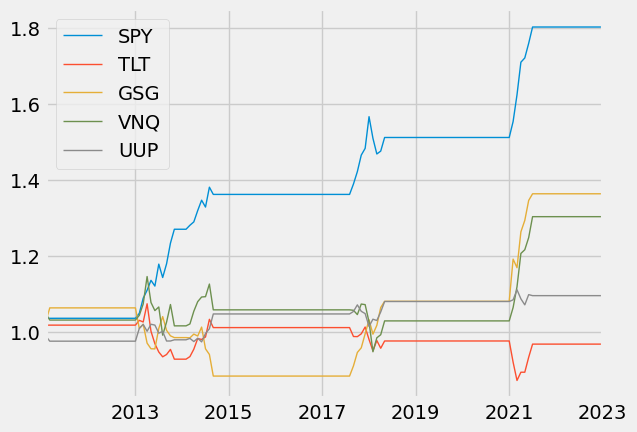

In [34]:
(1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['expansion'], axis=0)).cumprod().plot(lw=1)

In [35]:
for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.expansion).cumprod(), freq='month').numeric_metric()
    print()

SPY

TLT

GSG

VNQ

UUP



### 결과
      - expansion: 고성장/성장 상승 추세/고인플레이션, 고성장/성장 하락 추세/고인플레이션
      - 경기가 피크를 찍는 국면
      - 연준은 과열을 막기 위해 긴축정책을 시행
      - 결국 경기는 점차 둔화되기 시작
      - 고성장으로 주식도 좋은 성과를 보임
      - 고성장 고인플레인션 국면 -> 원자재 주식 다음으로 좋은 성과
        - 예외: 2013년 국제원자재가격은 신흥국의 수요 둔화, 생산 호조, 달러화 강세 및 투기자금 유입 감소 등으로 전반적으로 하향 안정되는 모습
        - https://www.bok.or.kr/portal/bbs/P0000528/view.do?nttId=196279&menuNo=200434&pageIndex=

### 인플레이션 국면

In [36]:
ma_regime_df

,SPY,TLT,GSG,VNQ,UUP,sp500_rets,deflation,inflation,recovery,expansion
2011-02-28,0.034737,0.016501,0.026451,0.047053,-0.012075,0.034737,0.0,0.0,0.0,1.0
2011-03-31,0.000120,0.000293,0.034913,-0.016107,-0.013581,0.000120,0.0,0.0,0.0,1.0
2011-04-30,0.028961,0.023391,0.042570,0.057466,-0.038550,0.028962,0.0,0.0,0.0,0.0
2011-05-31,-0.011214,0.034228,-0.068567,0.013747,0.018616,-0.011214,0.0,0.0,0.0,0.0
2011-06-30,-0.016870,-0.023230,-0.059553,-0.032993,-0.005623,-0.016870,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-30,-0.092446,-0.082351,-0.075056,-0.128713,0.035726,-0.092446,0.0,1.0,0.0,0.0
2022-10-31,0.081276,-0.059644,0.061710,0.035051,-0.003980,0.081276,0.0,1.0,0.0,0.0
2022-11-30,0.055592,0.071511,-0.011899,0.061461,-0.047286,0.055592,0.0,1.0,0.0,0.0
2022-12-31,-0.057628,-0.026200,-0.016674,-0.050343,-0.019407,-0.057628,0.0,1.0,0.0,0.0


<AxesSubplot: >

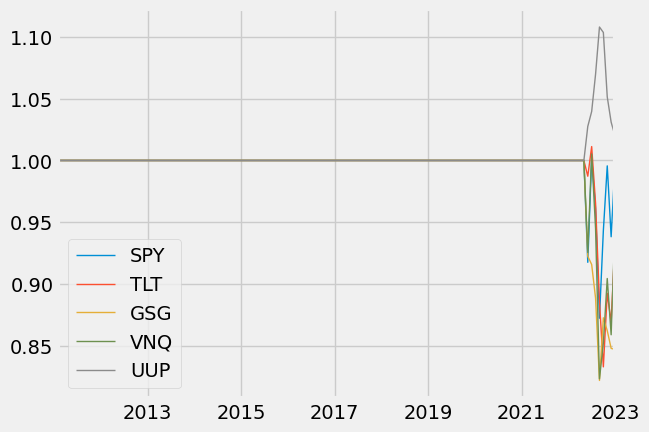

In [37]:
(1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['inflation'], axis=0)).cumprod().plot(lw=1)

In [ ]:
for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.inflation).cumprod(), freq='month').print_report()
    print()

In [ ]:
ma_regime_df[ma_regime_df.inflation != 0]

In [ ]:
ma_regime_df.inflation.iloc[-8:]
ma_regime_df.iloc[-8:]

### 결과
    - inflation: 저성장/성장 하락 추세/고인플레이션
    - 높은 인플레이션 유지되고 있지만 성장이 둔화 또는 침체되는 국면
    - 연준은 높은 인플레이션을 제어하기 위해 공적적으로 기준금리를 인상하게 되고 경기 둔화 폭이 확대
    - 높은 인플레이션으로 인해 원자재 가격이 일시적으로 크게 상승할 수 있지만 경기 둔화로 인한 수요 감소 폭이 커질 경우 급격한 조정을 받는다.
    - 달러 인덱스만 수익 발생 -> 회복기에서 상승, 후퇴기에 하락, 위축기에 상승. 하지만 달러는 안전자산의 역할도 하기 때문에 경제 위축기에 상승하는 모습을 보이기도 한다.  

### 위축국면

<AxesSubplot: >

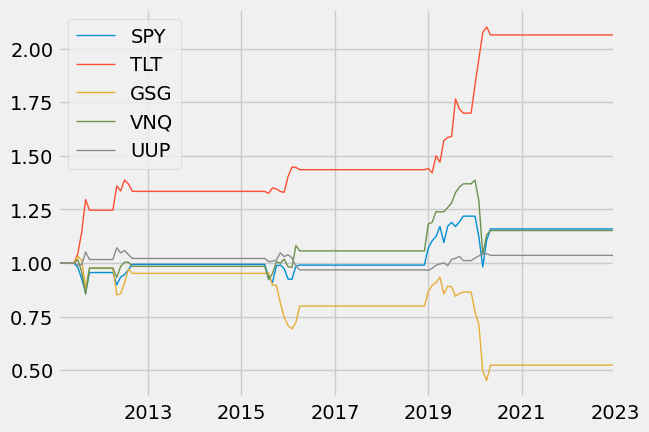

In [174]:
(1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['deflation'], axis=0)).cumprod().plot(lw=1)

In [ ]:
for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.deflation).cumprod(), freq='month').print_report()
    print()

### 결과
    - deflation: 저성장/성장 하락 추세/저인플레이션
    - 성장과 인플레이션이 모두 낮게 유지되는 국면
    - 위축 국면이 길어질수록 급격한 수요 감소와 디레버리징이 나타나게 되고 경기침체가 발생
    - 모든 위험 자산 가격이 크게 하락
    - 안전사잔인 장기채권과 달러가 가장 좋은 성과를 보임

### 종합
    - 회복국면
      - buy 주식, 부동산
      - sell 장기채권
    - 과열국면
      - buy 주식, 원자재
      - sell 장기 채권
    - 인플레이션
      - buy 달러
      - sell 주식
    - 위축국면
      - buy 장기채권
      - sell 주식, 부동산, 원자재
    
    - 추가 인사이트
      - 원자재는 거시경제의 영향과 수요와 공급(미시경제)의 영향 역시 많이 받는다. 
      -> 신문,기사 등의 영향을 추가하기 위해 NLP 사용해볼 수 있듯  

### 마지막으로 각 국면별 성과가 가장 좋은 자산군에 투자한다고 가정하고 백테스트 진행해보자

In [159]:
ma_regime_df

,SPY,TLT,GSG,VNQ,UUP,sp500_rets,deflation,inflation,recovery,expansion
2011-02-28,0.034738,0.016502,0.026451,0.047053,-0.012075,0.034737,0.0,0.0,0.0,1.0
2011-03-31,0.000120,0.000293,0.034913,-0.016107,-0.013581,0.000120,0.0,0.0,0.0,1.0
2011-04-30,0.028961,0.023391,0.042570,0.057465,-0.038550,0.028961,0.0,0.0,0.0,0.0
2011-05-31,-0.011215,0.034228,-0.068567,0.013747,0.018616,-0.011214,0.0,0.0,0.0,0.0
2011-06-30,-0.016870,-0.023230,-0.059553,-0.032992,-0.005623,-0.016870,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-30,-0.092446,-0.082351,-0.075056,-0.128713,0.035726,-0.092446,0.0,1.0,0.0,0.0
2022-10-31,0.081276,-0.059644,0.061710,0.035051,-0.003980,0.081276,0.0,1.0,0.0,0.0
2022-11-30,0.055592,0.071511,-0.011899,0.061461,-0.047286,0.055592,0.0,1.0,0.0,0.0
2022-12-31,-0.057628,-0.026200,-0.016674,-0.050343,-0.019407,-0.057628,0.0,1.0,0.0,0.0


<AxesSubplot: >

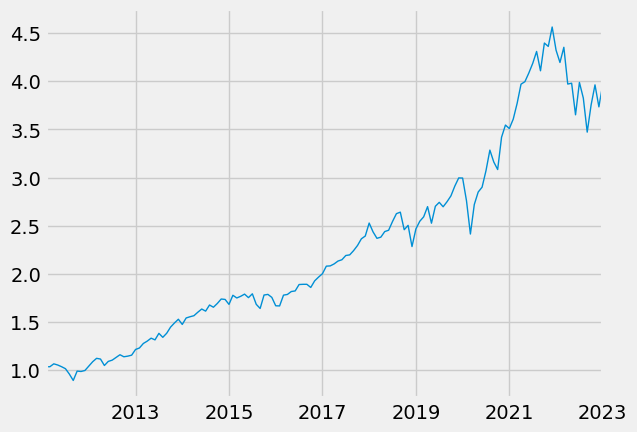

In [160]:
(1 + ma_regime_df['SPY']).cumprod().plot(lw=1)

In [161]:
Metric(portfolio=(1 + ma_regime_df['SPY']).cumprod(), freq='month').numeric_metric()

{'returns': '3.84',
 'CAGR': '0.12',
 'volatility': '0.15',
 'skewness': '-0.37',
 'kurtosis': '0.81',
 'MDD': '-0.24',
 'MDD_duration': '396.00',
 'sharp': '0.54',
 'sortino': '1.07',
 'calmar': '0.50',
 'VaR': '-0.09',
 'VaR_ratio': '0.11',
 'CVaR': '-0.11',
 'CVaR_ratio': '0.09',
 'hit': '0.69',
 'GtP': '0.86'}

In [162]:
print(len(ma_regime_df.loc[(ma_regime_df.recovery == 1)]['SPY']))
print(len(ma_regime_df.loc[(ma_regime_df.expansion == 1)]['SPY']))
print(len(ma_regime_df.loc[(ma_regime_df.deflation == 1)]['TLT']))
print(len(ma_regime_df.loc[(ma_regime_df.inflation == 1)]['UUP']))

36
34
33
8


In [163]:
best_regime = pd.concat([
                        ma_regime_df.loc[(ma_regime_df.recovery == 1)]['SPY'], 
                        ma_regime_df.loc[(ma_regime_df.expansion == 1)]['SPY'],
                        ma_regime_df.loc[(ma_regime_df.deflation == 1)]['TLT'],
                        ma_regime_df.loc[(ma_regime_df.inflation == 1)]['UUP'],
                        ], ignore_index=False, axis=0)

best_regime

2011-11-30   -0.004064
2011-12-31    0.010448
2012-01-31    0.046374
2012-02-29    0.043405
2012-03-31    0.032164
                ...   
2022-09-30    0.035726
2022-10-31   -0.003980
2022-11-30   -0.047286
2022-12-31   -0.019407
2023-01-31   -0.010787
Length: 111, dtype: float64

In [164]:
type(best_regime.index)
type(ma_regime_df.index)

best_regime.index = pd.to_datetime(best_regime.index)
best_regime.index

DatetimeIndex(['2011-11-30', '2011-12-31', '2012-01-31', '2012-02-29',
               '2012-03-31', '2012-04-30', '2012-10-31', '2012-11-30',
               '2012-12-31', '2013-01-31',
               ...
               '2020-04-30', '2020-05-31', '2022-06-30', '2022-07-31',
               '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30',
               '2022-12-31', '2023-01-31'],
              dtype='datetime64[ns]', length=111, freq=None)

In [165]:
not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained

DatetimeIndex(['2011-04-30', '2011-05-31', '2011-06-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-10-31', '2014-11-30',
               '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
               '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31'],
              dtype='datetime64[ns]', freq=None)

In [166]:
not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained_df = pd.Series({'port_val':0}, index=not_explained)

In [167]:
total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_8459/2470937050.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)


<AxesSubplot: >

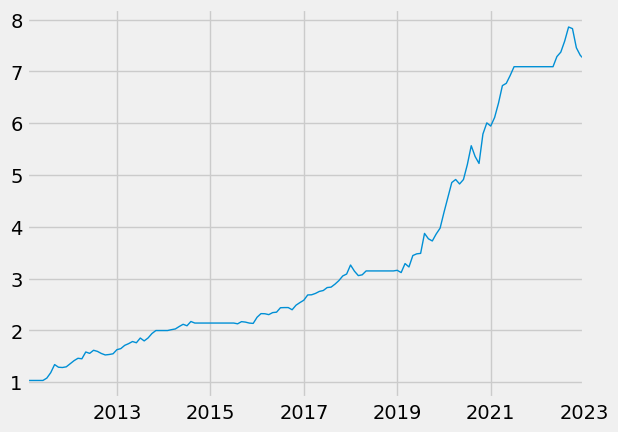

In [168]:
(1 + total_regime).cumprod().plot(lw=1)

In [173]:
_list = ['returns', 'CAGR', 'volatility', 'MDD','sharp']
tot_re = Metric(portfolio=(1 + total_regime).cumprod(), freq='month').numeric_metric()
_dict = {}
for i in _list:
    _dict[i] = [tot_re[i]]

tot_re = pd.DataFrame(_dict, index=['regime']).T
tot_re

,regime
returns,6.99
CAGR,0.18
volatility,0.10
MDD,-0.08
sharp,1.31


In [170]:
pd.DataFrame(Metric(portfolio=(1 + total_regime).cumprod(), freq='month').numeric_metric(), index=['total_regime'])

,returns,CAGR,volatility,skewness,kurtosis,MDD,MDD_duration,sharp,sortino,calmar,VaR,VaR_ratio,CVaR,CVaR_ratio,hit,GtP
total_regime,6.99,0.18,0.10,1.20,2.20,-0.08,487.00,1.31,4.70,2.21,-0.04,0.37,-0.04,0.33,0.71,1.92


### 결론 
- 단순 지수 투자보다 시황을 반영하는 것이 투자 성과를 개선
- 각 시황마다 지수들은 상이한 움직임을 보이고 이를 활용해 투자하는 것은 중요하다